In [1]:
#imports
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%run dataloader.ipynb

In [3]:
batch_size=2600
train_dataloader = DataLoader(train_set, collate_fn=collate_fn, batch_size=batch_size, shuffle=True)
dev_dataloader = DataLoader(dev_set, collate_fn=collate_fn, batch_size=1000, shuffle=True)
test_dataloader = DataLoader(test_set, collate_fn=collate_fn, batch_size=1000, shuffle=True)

In [4]:
gpu_id = 'cuda:3'
device = torch.device(gpu_id if torch.cuda.is_available() else 'cpu')

In [5]:
# multi layer linear
class MultiLayer(torch.nn.Module):

    def __init__(self, input_dim, hidden_layer_size) -> None:
        super().__init__()
        self.linear1 = torch.nn.Linear(20*input_dim, hidden_layer_size)
        self.dropout = torch.nn.Dropout(0.2)
        self.linear2 = torch.nn.Linear(hidden_layer_size, 1)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        h1 = torch.nn.functional.leaky_relu(self.linear1(x))
        h2 = self.dropout(h1)
        return self.linear2(h2)


step error


/tmp/ipykernel_3364198/4016921915.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_w=np.array(self.language_sdk[hid]['context_embedding_indexes'])
/tmp/ipykernel_3364198/4016921915.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_of=np.array(self.word_aligned_openface_sdk[hid]['context_features'])
/tmp/ipykernel_3364198/4016921915.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you 

1 0.71552973985672
dev error:  0.7847256064414978
2 0.6866025328636169
dev error:  0.6840800046920776
3 0.682052493095398
dev error:  0.6902745962142944
4 0.6594868898391724
dev error:  0.687656581401825
5 0.6501629948616028
dev error:  0.6764499545097351
6 0.6466951370239258
dev error:  0.6761032342910767
7 0.6375963687896729
dev error:  0.6820253729820251
8 0.6237716674804688
dev error:  0.6749874949455261
9 0.620297372341156
dev error:  0.6747585535049438
10 0.6061139106750488
dev error:  0.6720737814903259
11 0.5994778871536255
dev error:  0.6721698641777039
12 0.590377688407898
dev error:  0.6718828678131104
13 0.5873397588729858
dev error:  0.6694179773330688
14 0.5678422451019287
dev error:  0.6704818606376648
15 0.569064736366272
dev error:  0.6734811067581177
16 0.5558812618255615
dev error:  0.6753247380256653
17 0.54107666015625
dev error:  0.6786374449729919
18 0.5396151542663574
dev error:  0.6824461817741394
19 0.5248420834541321
dev error:  0.6824727654457092
20 0.506470

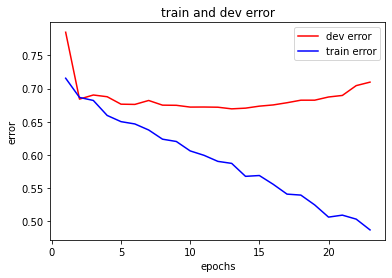

best model after 13 epochs with dev set error 0.6694179773330688


In [16]:
idxs_text = torch.arange(300) # text, 300
idxs_speech = torch.arange(300, 381) # speech, 81
idxs_visual = torch.arange(381, 752) # visual, 371
idxs_text_speech = torch.arange(381) # text + speech, 381
idxs_text_visual = torch.cat((torch.arange(300), torch.arange(381, 752))) # text + visual, 671
idxs_speech_visual = torch.arange(300, 752) # speech + visual, 452
idxs_all = torch.arange(752) # text + speech + visual, 752

model = MultiLayer(input_dim=381, hidden_layer_size=256)
model.to(device)

optimiser = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.002)
epochs = 500
patience = 10

print('step', 'error')
dev_errors = []
best_dev_error = np.inf
errors = []
num_bad_epochs = 0
num_epochs = 0
best_epoch = 0
for epoch in range(1, epochs+1):
    model.train()
    for batch_idx, batch in enumerate(train_dataloader, 0):
        x_p,x_c,y,hid,x_p_len=map(lambda x: x.to(device), batch)
        optimiser.zero_grad()
        output = model(x_p[:, :, idxs_text_speech])
        error = torch.nn.functional.binary_cross_entropy_with_logits(output, y)
        error.backward()
        optimiser.step()
    
    print(epoch, error.detach().tolist())
    errors.append(error.detach().tolist())

    with torch.no_grad():
        model.eval()
        matches = 0
        total = 0
        for batch_idx, batch in enumerate(dev_dataloader, 0):
            x_p,x_c,y,hid,x_p_len=map(lambda x: x.to(device), batch)
            dev_output = model(x_p[:, :, idxs_text_speech])
            dev_error = torch.nn.functional.binary_cross_entropy_with_logits(dev_output, y)
        dev_errors.append(float(dev_error))
        print('dev error: ', float(dev_error))

    if dev_error < best_dev_error:
        num_bad_epochs = 0
        best_dev_error = dev_error
        best_epoch = epoch
        torch.save(model, 'punchline_multilayer_baseline_text-speech.pth')
    else:
        num_bad_epochs += 1
        if num_bad_epochs == patience:
            num_epochs = epoch
            break

plt.plot(range(1, num_epochs+1), dev_errors, 'r', label='dev error')
plt.plot(range(1, num_epochs+1), errors, 'b', label='train error')
plt.title('train and dev error')
plt.xlabel('epochs')
plt.ylabel('error')
plt.legend()
plt.show()

print('best model after {} epochs with dev set error {}'.format(best_epoch, best_dev_error))
rnn = torch.load('punchline_multilayer_baseline_text-speech.pth')

In [17]:
hid_humor_t = {}
hid_humor_f = {}
hid_nonhumor_t = {}
hid_nonhumor_f = {}

with torch.no_grad():
    matches = 0
    total = 0
    for batch_idx, batch in enumerate(test_dataloader, 0): 
        x_p,x_c,y,hid, x_p_len=map(lambda x: x.to(device), batch)
        output = model(x_p[:, :, idxs_text_speech])
        error = torch.nn.functional.binary_cross_entropy_with_logits(output, y)
        scaled_outputs = torch.sigmoid(output)
        predictions = (scaled_outputs > 0.5)*1
        matches += (y == predictions).sum()
        total += len(y)
        for j, id in enumerate(hid.detach().tolist()):
            if predictions[j] == 1 and y[j] == 1:
                hid_humor_t[id] = scaled_outputs[j].detach().tolist()[0]
            elif predictions[j] == 1 and y[j] == 0:
                hid_humor_f[id] = scaled_outputs[j].detach().tolist()[0]
            elif predictions[j] == 0 and y[j] == 0:
                hid_nonhumor_t[id] = scaled_outputs[j].detach().tolist()[0]
            elif predictions[j] == 0 and y[j] == 1:
                hid_nonhumor_f[id] = scaled_outputs[j].detach().tolist()[0]
            else:
                print('something is wrong')
    acc = matches / total
    print('test error: ', float(error))
    print('test accuracy: {:.2%}'.format(float(acc)))

/tmp/ipykernel_3364198/4016921915.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_w=np.array(self.language_sdk[hid]['context_embedding_indexes'])
/tmp/ipykernel_3364198/4016921915.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_of=np.array(self.word_aligned_openface_sdk[hid]['context_features'])
/tmp/ipykernel_3364198/4016921915.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you 

test error:  0.6613044142723083
test accuracy: 62.24%
